# Intermittent Sending Optimization

This jupyter notebook takes in a tactile sensing hdf5 recording and does a grid search to help find optimal parameters for 
the WiReSens Toolkit intermittent sending algorithm: p (the proportional control parameter) and d (the error threshold for sending)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

def tactile_reading(path):
    """
    Reads tactile sensor data from an HDF5 file.

    This function opens an HDF5 file at the specified path and extracts 
    tactile sensor data, including frame count, timestamps, pressure readings, 
    and packet IDs. The data is then returned as numpy arrays.

    Parameters:
    path (str): The path to the HDF5 file containing the tactile sensor data.

    Returns:
    tuple:
        pressure (np.ndarray): An array of pressure readings with shape (frame_count,rows,cols). (32x32 by default)
        frame_count (int): The number of frames (or data points) in the file.
        ts (np.ndarray): An array of timestamps with shape (frame_count,).
        packetIDs (np.ndarray): An array of packet IDs with shape (frame_count,9). Represents all packetIDs received during a frame. 
    """
    f = h5py.File(path, 'r')
    fc = f['frame_count'][0]
    ts = np.array(f['ts'][:fc//2])
    pressure = np.array(f['pressure'][:fc]).astype(np.float32)
    packetIDs = np.array(f['packetNumber'][:fc])
    return pressure, fc, ts, packetIDs

# Define the prediction function
def predict_value(pressure, frame, y, x, p):
    """
    Predicts the pressure at a particular sensing node for the next frame

    Parameters:
    pressure (np.ndarry): An array of pressure readings with shape (frame_count,rows,cols).
    frame (int): The current frame's index
    y (int): Index representing the reading wire
    x (int): Index representing the grounding wire
    p (int): Proportional control parameter

    Returns: int

    """
    if frame == 0:
        return pressure[frame,y,x]  # No previous value, use initial value
    return max(0,pressure[frame,y,x] + 1 / (p) * (pressure[frame,y,x] - pressure[frame-1,y,x]))

def copyInto(predPressure,arr,startIdx):
    """ 
    Copies the array arr into the predicted pressures array

    Parameters:

    predPressure (np.ndarry): An array of predicted pressure readings
    arr (np.ndarry): Pressure readings to be copied
    startIdx (int): Index to copy from


    """
    totalElements = predPressure.size
    end_index = startIdx +len(arr)
    if end_index > totalElements:
        end_index = totalElements
    # Calculate the number of elements that can be copied
    num_elements_to_copy = end_index - startIdx

    # Use numpy.ravel to get a flat view of the 3D array
    flat_array = predPressure.ravel()
    
    # Copy the elements from array_1d to the flat view of the 3D array
    flat_array[startIdx:startIdx + num_elements_to_copy] = arr[:num_elements_to_copy]

def calcMetricsReturnPred(filePath,p,d):
    truePressure = tactile_reading(filePath)[0]
    predPressure = np.zeros(truePressure.shape)
    predPressure[0:2]=truePressure[0:2]
    totalError = 0
    avgError = 0
    lastIndex = truePressure.shape[0]*truePressure.shape[1]*truePressure.shape[2]
    transmitted_data_count = 0
    packetCount = 0
    numNodes = 120
    preds = np.zeros(numNodes)
    trues = np.zeros(numNodes)
    frame = 2
    startIdx = 0
    lastFrameReached = False
    while not lastFrameReached:
        for y in range(truePressure.shape[1]):
            for x in range(truePressure.shape[2]):
                if packetCount==0:
                    startIdx = frame*truePressure.shape[1]*truePressure.shape[2]+truePressure.shape[2]*y+x
    
                pred = predict_value(predPressure,frame-1,y,x,p)
                preds[packetCount] = pred
                trues[packetCount] = truePressure[frame,y,x]
                totalError += abs(pred-truePressure[frame,y,x])
                if packetCount == numNodes-1:
                    avgError = totalError/numNodes
                    if avgError > d:
                        transmitted_data_count+=1
                        copyInto(predPressure,trues,startIdx)
                    else:
                        copyInto(predPressure,preds,startIdx)
                    packetCount = 0
                    totalError = 0
                    preds=np.zeros(numNodes)
                    trues=np.zeros(numNodes)

                else:
                    packetCount +=1
                if frame*truePressure.shape[1]*truePressure.shape[2]+truePressure.shape[2]*y+x == lastIndex -1:
                    lastFrameReached = True
                    break
                if y==truePressure.shape[1]-1 and x==truePressure.shape[2]-1:
                    frame+=1


    # Compute the RMSE
    error = predPressure - truePressure
    mse = np.mean(error ** 2)
    rmse_value = np.sqrt(mse)
    range_y = np.max(truePressure) - np.min(truePressure)
    nrmse = rmse_value/range_y
    transmitted_percentage = transmitted_data_count /(lastIndex//numNodes)
    return nrmse, transmitted_percentage, predPressure
    
    
# Calculate the NRMSE and the percentage of transmitted data for given values of p and d
def calculate_metrics(filePath, p, d):
    truePressure = tactile_reading(filePath)[0]
    predPressure = np.zeros(truePressure.shape)
    predPressure[0:2]=truePressure[0:2]
    totalError = 0
    avgError = 0
    lastIndex = truePressure.shape[0]*truePressure.shape[1]*truePressure.shape[2]
    transmitted_data_count = 0
    packetCount = 0
    numNodes = 120
    preds = np.zeros(numNodes)
    trues = np.zeros(numNodes)
    frame = 2
    startIdx = 0
    lastFrameReached = False
    while not lastFrameReached:
        for y in range(truePressure.shape[1]):
            for x in range(truePressure.shape[2]):
                if packetCount==0:
                    startIdx = frame*truePressure.shape[1]*truePressure.shape[2]+truePressure.shape[2]*y+x
    
                pred = predict_value(predPressure,frame-1,y,x,p)
                preds[packetCount] = pred
                trues[packetCount] = truePressure[frame,y,x]
                totalError += abs(pred-truePressure[frame,y,x])
                if packetCount == numNodes-1:
                    avgError = totalError/numNodes
                    if avgError > d:
                        transmitted_data_count+=1
                        copyInto(predPressure,trues,startIdx)
                    else:
                        copyInto(predPressure,preds,startIdx)
                    packetCount = 0
                    totalError = 0
                    preds=np.zeros(numNodes)
                    trues=np.zeros(numNodes)

                else:
                    packetCount +=1
                if frame*truePressure.shape[1]*truePressure.shape[2]+truePressure.shape[2]*y+x == lastIndex -1:
                    lastFrameReached = True
                    break
                if y==truePressure.shape[1]-1 and x==truePressure.shape[2]-1:
                    frame+=1


    # Compute the NRMSE
    error = predPressure - truePressure
    mse = np.mean(error ** 2)
    rmse_value = np.sqrt(mse)
    range_y = np.max(truePressure) - np.min(truePressure)
    nrmse = rmse_value/range_y
    transmitted_percentage = transmitted_data_count /(lastIndex//numNodes)
    return nrmse, transmitted_percentage

# Objective function to minimize
def objective(params, filePath, alpha=0.5):
    p, d = params
    nrmse, transmitted_percentage = calculate_metrics(filePath, p, d)
    return alpha * nrmse + (1 - alpha) * transmitted_percentage, nrmse, transmitted_percentage

# Generate a grid of p and d values
def generate_grid(p_range, d_range, num_points):
    p_values = np.linspace(p_range[0], p_range[1], num_points)
    d_values = np.linspace(d_range[0], d_range[1], num_points)
    P, D = np.meshgrid(p_values, d_values)
    return P, D

# Calculate objective function values over the grid with constraint
def calculate_objective_grid(filePath, P, D, alpha):
    best={}
    Z = np.zeros_like(P)
    for i in range(P.shape[0]):
        for j in range(P.shape[1]):
            print(f"Iteration Number: {i*P.shape[1]+j}, P: {P[i,j]}, D: {D[i,j]}")
            objValue,nrmse,transmit = objective((P[i, j], D[i, j]), filePath, alpha)
            if "value" not in best:
                best["P"]=P[i,j]
                best["D"]=D[i,j]
                best["value"]=objValue
                best["nrmse"]= nrmse
                best["transmit"] = transmit
            elif objValue < best["value"]:
                best["P"]=P[i,j]
                best["D"]=D[i,j]
                best["value"]=objValue
                best["nrmse"]=nrmse
                best["transmit"]=transmit
            Z[i, j] = objValue
    return Z, best

## Optimize Intermittent Sending Parameters

In [ ]:
# Recording to use for optimization
filePath = "./recordings/4000.hdf5"

# Define ranges for p and d
p_range = (20, 100)
d_range = (20, 100)
num_points = 20

# Define the weight for NRMSE in the objective function
alpha = 0.75

# Generate the grid and calculate the objective function values with constraint
P, D = generate_grid(p_range, d_range, num_points)
Z, best = calculate_objective_grid(filePath, P, D, alpha)
print(f"Best params are:")
print(f"Optimal p: {best["P"]}")
print(f"Optimal d: {best["D"]}")
print(f"Best NRMSE: {best["nrmse"]}")
print(f"Best Transmitted Percentage: {best["transmit"]}")

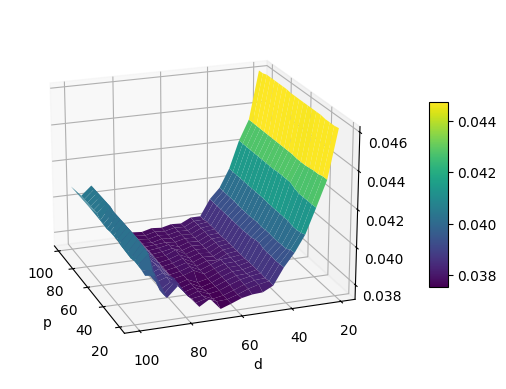

In [17]:
  # Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(P, D, Z, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)  # Add a colorbar

ax.set_xlabel('p')
ax.set_ylabel('d')
# Set the view angle
ax.view_init(elev=20, azim=160)  # Adjust these values as needed
plt.savefig("pillowIntermittent.svg")
plt.show()